# Exploratory data analysis and model building on early stage diabetes risk prediction dataset. 
The data set was obtained from Kaggle. Below the first cell set the directory to the root directory in order make the import easier. Retstart the notebook inrder to re-run all cells. This notebook will describe EDA and classification model building by using hyper parameter tuning and finally prediction of the best models on test set. 

In [1]:
%cd ..

c:\Users\abhik\Documents\healthcare_data_projetcs


In [2]:
import pandas as pd
import json
from utils.eda_utils import DataFrameInfo, DataFrameTransform, DataFrameVisualize, DataTransform
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import Type, Callable
import joblib


from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Next cell imports some useful functionality from the utility file eda_utils.py. 

In [3]:
data_transform = DataTransform()
dataframe_transform = DataFrameTransform()
data_plot = DataFrameVisualize()
dataframe_info = DataFrameInfo()

In [4]:
df = pd.read_csv("data/diabetes_data_upload.csv")

In [5]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


## Exploratory data analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [7]:

numerical_columns = dataframe_info.list_all_numeric_columns(df)
categorical_columns = dataframe_info.list_all_categorical_columns(df)

In [8]:
print(f"List of numerical columns: {numerical_columns} and number {len(numerical_columns)}")
print(f"List of categorical columns: {categorical_columns} and number {len(categorical_columns)}")


List of numerical columns: ['Age'] and number 1
List of categorical columns: ['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 'Irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class'] and number 16


Univariate analysis of the column Age. We will check the skewness and distribution of thios column. 

In [9]:
df["Age"].skew()

0.3293593578272701

<AxesSubplot:xlabel='Age', ylabel='Count'>

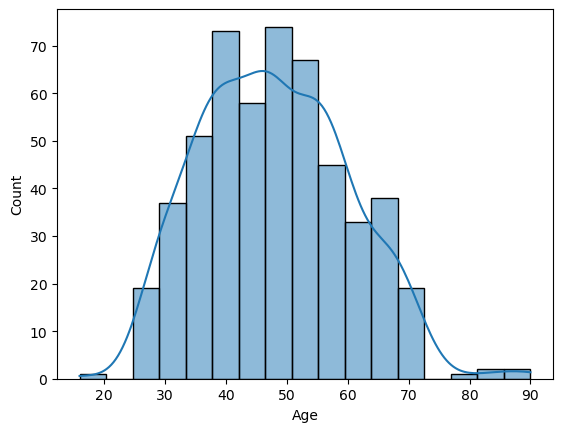

In [10]:
data_plot.plot_histogram(df, "Age")

Next we will plot the probability distribution plot for all categorical columns

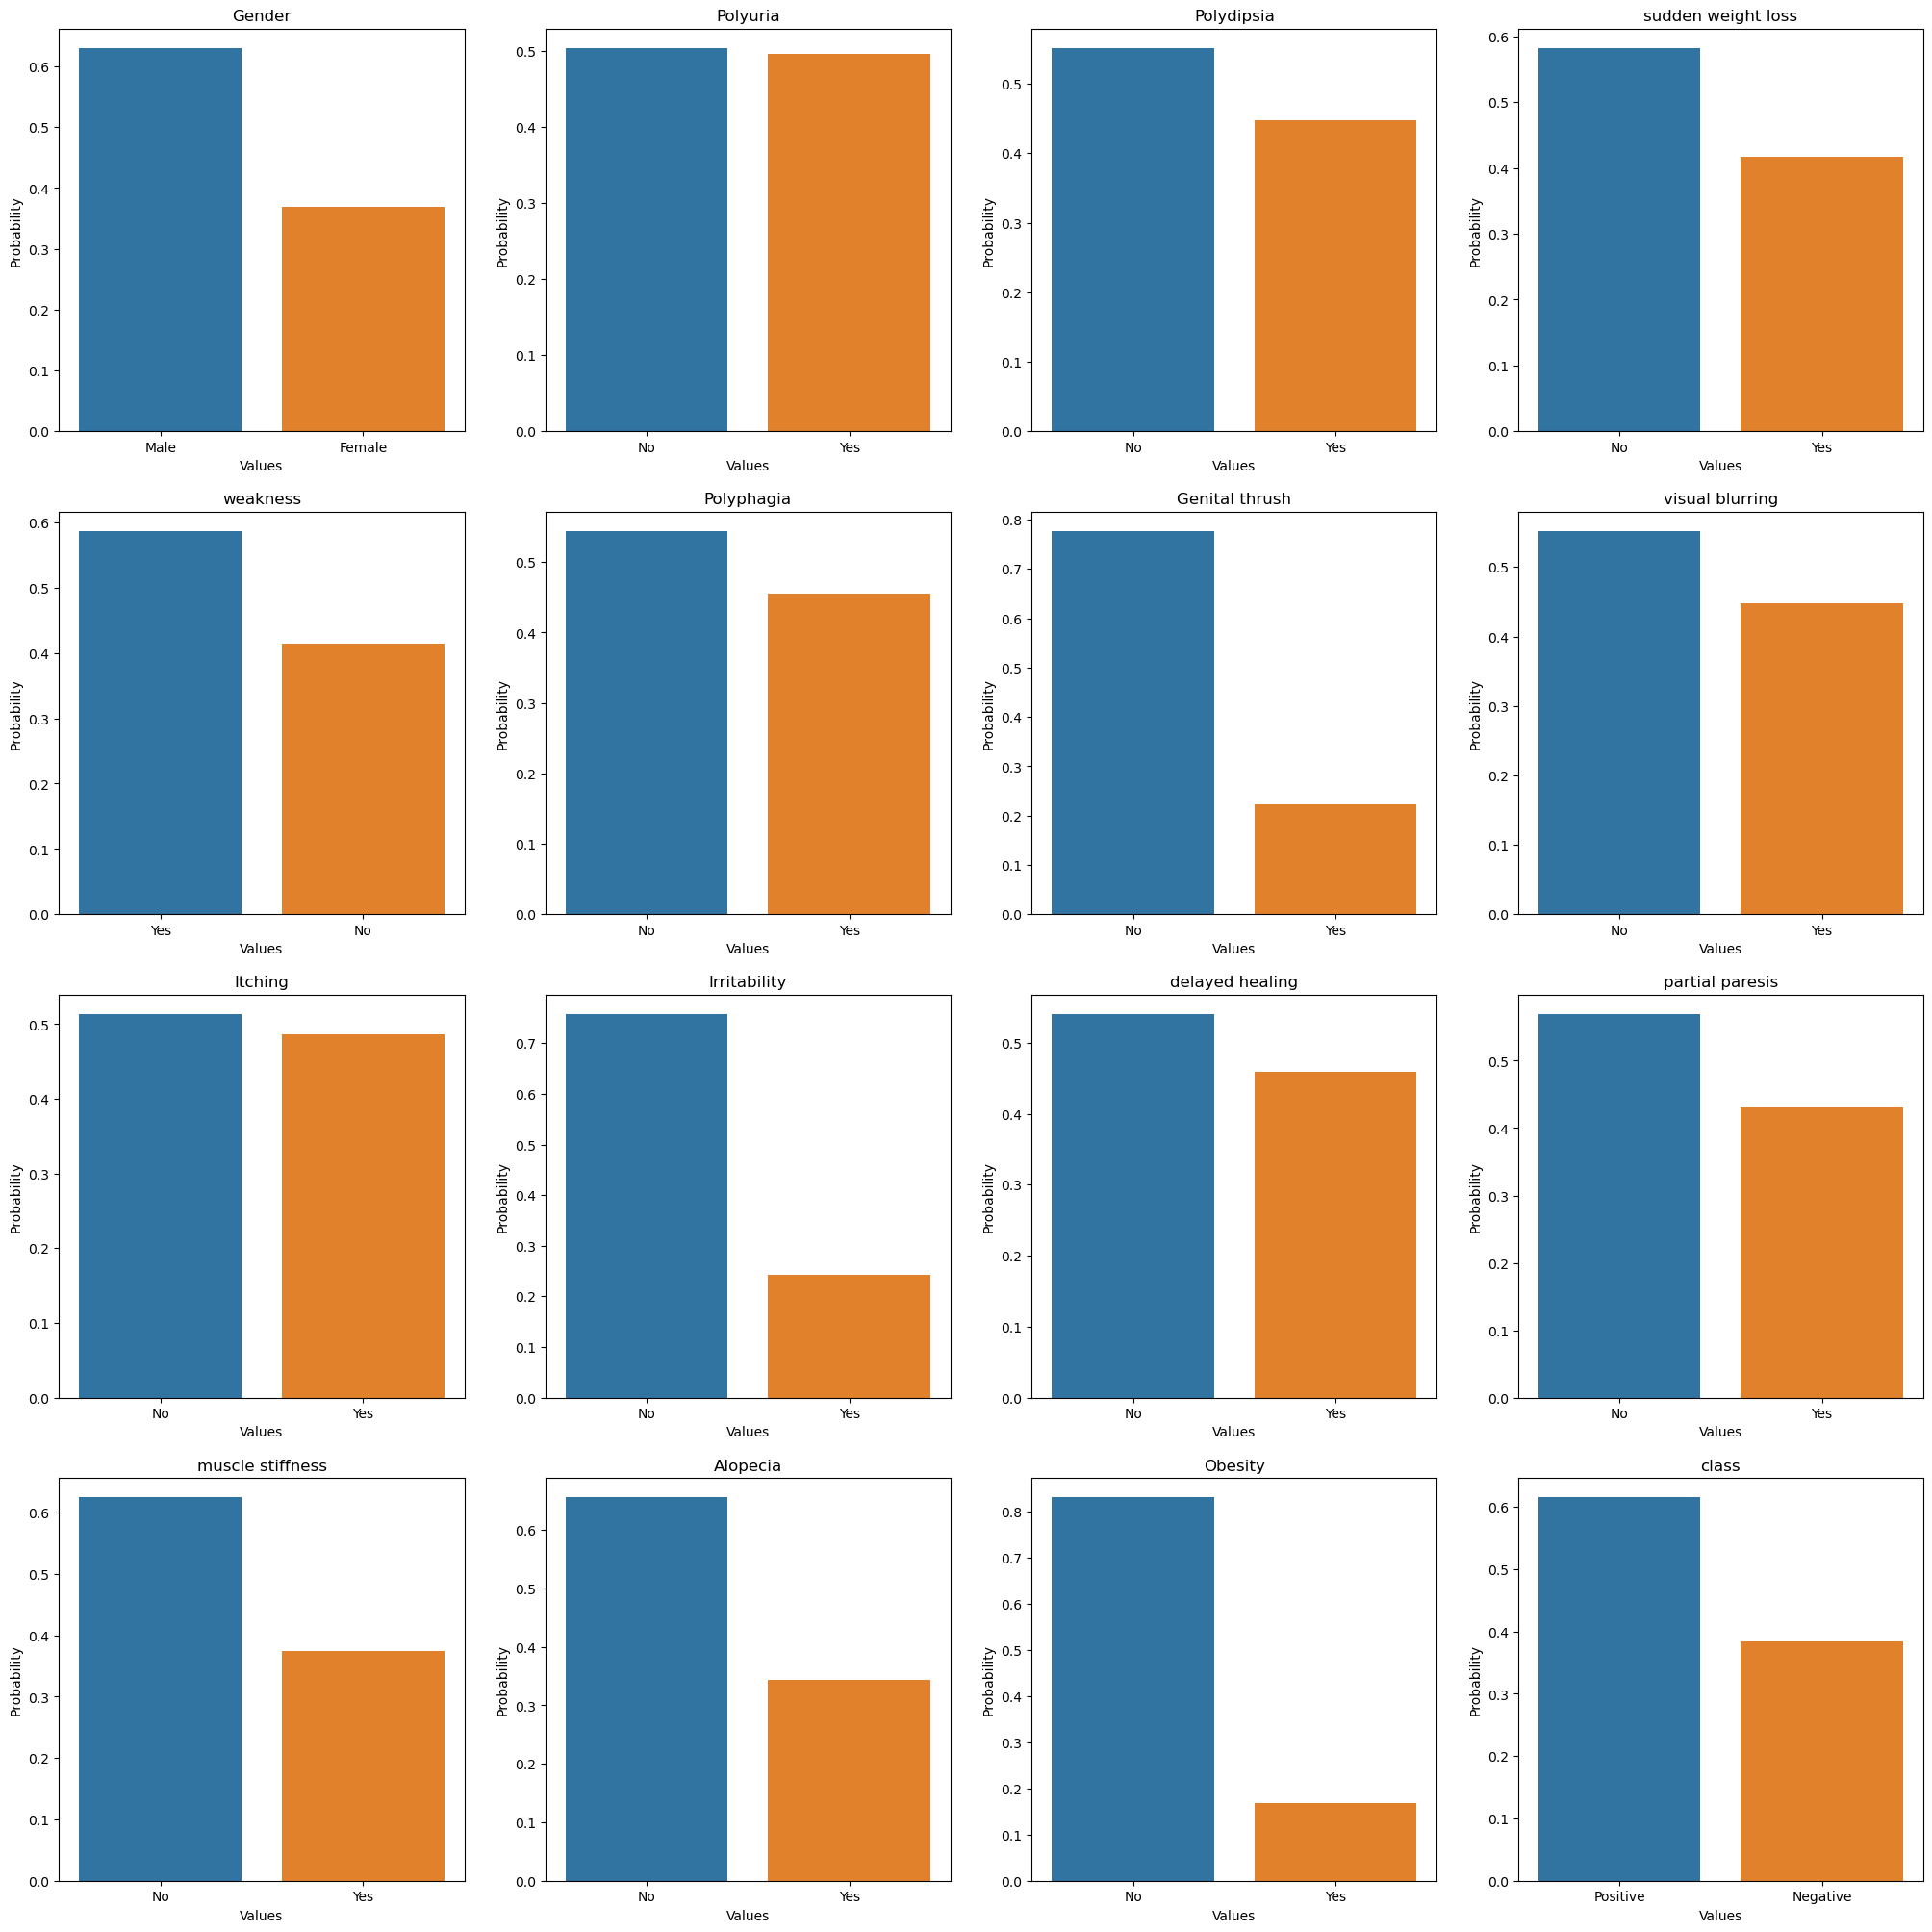

In [11]:
for i, column in enumerate(categorical_columns, 1):
    plt.rcParams["figure.figsize"] = (25,25)
    plt.subplot(4,4,i)
    data_plot.plot_prob_distribution(df, column)

Next we will find some bivariate analysis to find more insight from this dataset.

In [12]:
def plot_sns_count_plot(x_axis_column, hue_columns):
    sns.set_theme(rc={'figure.figsize':(6,4)})

    sns.countplot(df, x=x_axis_column, hue= hue_columns)

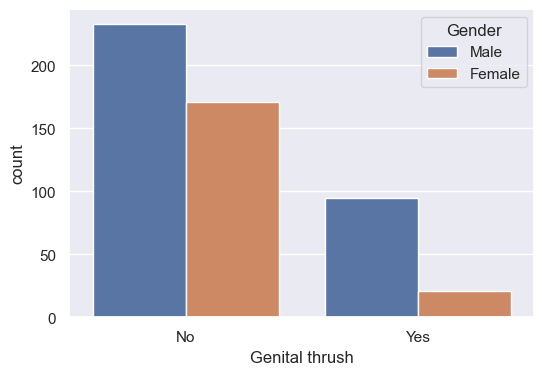

In [13]:
plot_sns_count_plot(x_axis_column="Genital thrush", hue_columns="Gender")

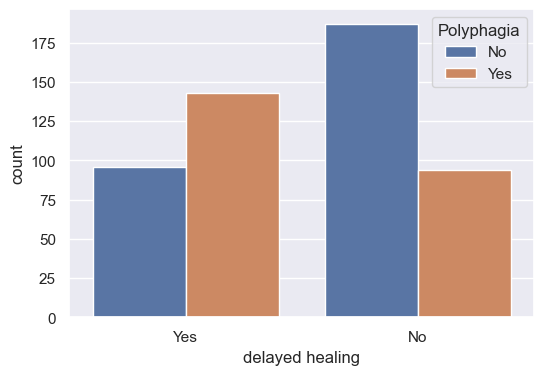

In [14]:
plot_sns_count_plot(x_axis_column="delayed healing", hue_columns="Polyphagia")

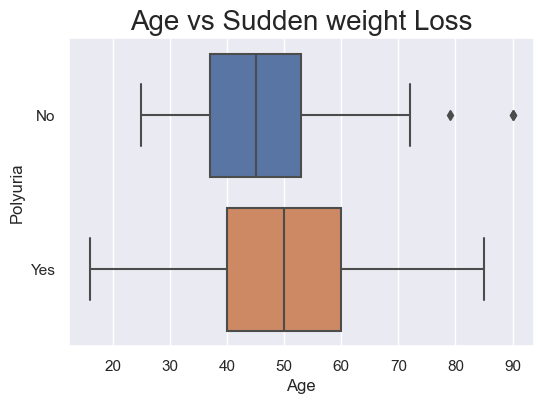

In [15]:
sns.boxplot(x=df['Age'], y=df['Polyuria'])
plt.title('Age vs Sudden weight Loss', fontsize = 20)
plt.show()

## Data transformation and preperation

In [16]:
X = df.drop("class", axis=1)
y = df["class"]

In [17]:
categorical_columns_without_label = dataframe_info.list_all_categorical_columns(X)

In [18]:
categorical_columns_without_label

['Gender',
 'Polyuria',
 'Polydipsia',
 'sudden weight loss',
 'weakness',
 'Polyphagia',
 'Genital thrush',
 'visual blurring',
 'Itching',
 'Irritability',
 'delayed healing',
 'partial paresis',
 'muscle stiffness',
 'Alopecia',
 'Obesity']

In [19]:
full_pipeline = make_column_transformer(
    (MinMaxScaler(), numerical_columns ),
    (OneHotEncoder(sparse_output=False), categorical_columns_without_label)
)

In [20]:
X = full_pipeline.fit_transform(X)

In [21]:
X.shape

(520, 31)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [23]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(520, 31)
(416, 31)
(52, 31)
(52, 31)


## Model training
We will first check the baseline model performance with logistic regression model from Scikit learn. 

In [24]:
log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs")
log_reg.fit(X_train, y_train)
y_predictions = log_reg.predict(X_test)

In [25]:
print(f"Base line model accuracy score {accuracy_score(y_test, y_predictions)}")
print(
        f"Base line model precision score {precision_score(y_test, y_predictions, average='weighted')}"
    )
print(
        f"Base line model recall score {recall_score(y_test, y_predictions, average='weighted')}"
    )
print(
        f"Base line model f1 score {f1_score(y_test, y_predictions, average='weighted')}"
    )


Base line model accuracy score 0.8846153846153846
Base line model precision score 0.8846153846153846
Base line model recall score 0.8846153846153846
Base line model f1 score 0.8846153846153846


Next we will design a hyper parameter tuning experiments with a list fo models using GridsearhCV algorithm. We will provide the hyperparameters by using a json file and evaluate the best model based on the performance on the validation set. After that we will retrain the best model on the training set and then check the final prediction on the test set.

In [26]:
def read_json_file(file_path: str) -> dict:
    """Reads a JSON file and returns a dictionary."""
    with open(file_path, "r") as f:
        return json.load(f)

In [27]:
def _tune_model_hyperparameters(
    model,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    param_dict: dict,
) -> dict:
    """Tunes the hyperparameters of a regression model using grid search."""
    model_instance = model()
    grid_search = GridSearchCV(model_instance, param_dict, cv=5)
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_  #

In [28]:
def evaluate_all_models(
    list_of_models: list,
    param_file: str,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.DataFrame,
    scoring_metric: Callable,
) -> dict:
    """Evaluates a list of models using grid search and saves the best model."""
    param_dict = read_json_file(param_file)

    results_dict = {}
    for model_name in list_of_models:
        model_instance = eval(model_name)  # Convert string to class

        best_parameters = _tune_model_hyperparameters(
            model_instance, X_train, y_train, param_dict[model_name]["params"]
        )
        model_with_best_parameters = model_instance(**best_parameters)
        model_with_best_parameters.fit(X_train, y_train)
        best_validation_score = scoring_metric(
            y_val, model_with_best_parameters.predict(X_val)
        )

        results_dict[model_name] = {
            "best_params": best_parameters,
            "best_validation_score": best_validation_score,
        }
        # joblib.dump(model_with_best_parameters, f"diabetes_risk_prediction/{model_name}.joblib") # since we changed our folder to root folder earlier

    return results_dict

In [29]:
def find_best_model(result_dict: dict) -> tuple:
    """Finds the best model from a dictionary of results."""
    best_score = np.inf
    best_performing_model = None
    best_params = None
    for model, model_results in result_dict.items():
        if model_results["best_validation_score"] < best_score:
            best_score = model_results["best_validation_score"]
            best_performing_model = model
            best_params = model_results["best_params"]
    return best_performing_model, best_score, best_params

In [30]:
list_of_methods = [
        "RandomForestClassifier",
        "GradientBoostingClassifier",
        "DecisionTreeClassifier",
    ]
    

In [31]:
hyperparameter_file = "hyperparameter_json_files/classification_hyperparameters.json"

In [32]:
results = evaluate_all_models(
        list_of_models=list_of_methods,
        param_file=hyperparameter_file,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        scoring_metric=accuracy_score,
    )

In [33]:
print(
        f"Best model, Accuracy and parameters : {find_best_model(results)}"
    )

Best model, Accuracy and parameters : ('RandomForestClassifier', 0.9807692307692307, {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 500})


In [34]:
best_model, score, params = find_best_model(results)

In [35]:
best_model_instance = eval(best_model)

In [36]:
best_model = best_model_instance(**params)

In [37]:
best_model.fit(X_train, y_train)

print(
        f"Accuracy of best classification model on test data : {accuracy_score(y_test, y_predictions)}"
    )
print(
        f"Precision of best classification model on test data : {precision_score(y_test, y_predictions, average='weighted')}"
    )
print(
        f"Recall of best classification model on test data : {recall_score(y_test, y_predictions, average='weighted')}"
    )
print(
        f"F1 score of best classification model on test data : {f1_score(y_test, y_predictions, average='weighted')}"
    )

Accuracy of best classification model on test data : 0.8846153846153846
Precision of best classification model on test data : 0.8846153846153846
Recall of best classification model on test data : 0.8846153846153846
F1 score of best classification model on test data : 0.8846153846153846


In [38]:
cm = confusion_matrix(y_test, y_predictions, labels=best_model.classes_)

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

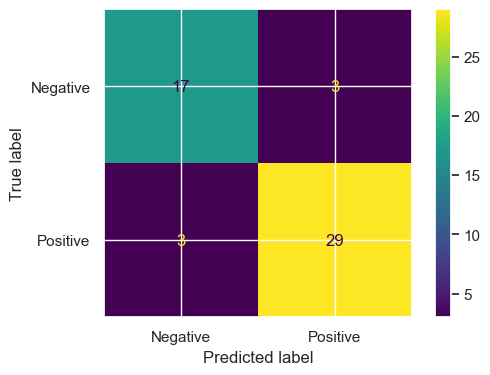

In [40]:
disp.plot()